<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2023<br>
<font color=3C99D size=5>
    Practical Assignment 1 - Search <br>
<font color=696880 size=4>
    Mohammad Mahdi Abootorabi and Roozbeh Pirayadi 

____

# Personal Data

In [1]:
# Set your student number
student_number = '400104929'
Name = 'Taraneh'
Last_Name = 'Khosrojerdi'

# Rules
- Make sure that all of your cells can be run perfectly. 
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**. 
- There is one cell for your custom functions (if you need any) at the beginning of each question. Please note that this jupyter file might be broken down into 3 or 4 jupyter notebooks for easier grading, so you **must write your custom functions in the correct cell**.

# Q2: Simulated Annealing (100 Points)

<font size=4>
Author: Mohammad Mahdi Abootorabi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

## Libraries

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [3]:
# place for your custom functions here

## Knapsack Problem

In this problem, we will tackle the knapsack problem with using simulated annealing algorithm. You can find more detail about this problem [here](https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/).


To use local search algorithms, we must define our state-space. As the problem is about choosing a object or not, we define each state as a vector $S$ of size $n$ ( $n$ is total number of objects). 

$$
S_i=   \left\{
\begin{array}{ll}
      1 & \text{object $i$ is selected} \\
      0 & \text{object $i$ is not selected}
\end{array} 
\right.
$$

Write a function that generates a random state. i.e., it must return a boolean vector of size n. p is probablity of selecting an object. For example, if p=0.5, then the function must return a vector of size n in which each element is selected with 50% probability.

In [4]:
def random_state_generator(n, p=0.5):
    ##################################################################
    # (5 Points)                                                     #
    # This function get input n (length) and probability of True for #
    # each element of the vector (p) and generates and returns a     #
    # random boolean vector (list) with length n.                    #
    ##################################################################
    output = [random.choices([True, False], [p, 1 - p], k=1)[0] for _ in range(n)]
    return output

## 

## Value Function

Our Proposed Value function is:

$$
f(S) =   \left\{
\begin{array}{ll}
      \sum_{i=1}^{n} s_{i} v_{i} & \text{if  $\sum_{i=1}^{n} s_{i} w_{i} \leq W $ } \\
      0 & \text{Otherwise}
\end{array} 
\right.
$$

Note that: 

n = length of items

$s_i$ = ith item of state S

$v_i$ = ith value 

$w_i$ = ith weight 

$W$ = knapsack weight 



In [5]:
def value_function(W, weights, values, state):
    ##################################################################
    # (10 Points)                                                    #
    # This function gets a state and values and weights and W,       #
    # and calculates the value of this state                         #
    ##################################################################
    
    sw = 0
    sv = 0
    for i in range(0, len(weights)):
        sw += weights[i] * state[i]
        sv += values[i] * state[i]
    if sw <= W:
        return sv
    return 0

## Acceptance probability function

the acceptance probability function calculates the probability of accepting a worse solution. It is defined as:
$$
P = e^{- \frac{(f(S_{old}) - f(S_{new}))^{1.5}}{T} }
$$

In [6]:
def prob_accept(state_value, next_state_value, temperature):
    ##################################################################
    # (15 Points)                                                    #
    # This function gets a state value, a next state value,          #
    # and the temperature and calculates the probability             #
    # of accepting the next state based on the formula               #
    # given in the assignment                                        #
    # NOTE: Feel free to change the formula if you want to.          #
    ##################################################################

    power = -(((state_value - next_state_value) ** 1.5) / temperature)
    return math.exp(power)

## Neighbor state generator

The neighbor state generator generates a neighbor state of the current state. Our neighbor state generator is defined as:

1- Select a random index $i$ from $[1, n]$.

2- Flip the value of $S_i$.

3- With probablity of 'prob' flip the value of another random index $j$ from $[1, n]$.

4- If this state is feasible(the sum of weights of selected objects is less than or equal to the knapsack weight), return this state. Otherwise, Continue from step 1.


In [7]:
def neighbor_state_generator(state, W, weights, values, prob=0.5):
    ############################################################################
    # (15 Points)                                                              #
    # This function gets a state, W, weights, values, and probability of       #
    # flipping the second bit and generates a neighbor state                   #
    # NOTE: You can use the value_function to check if the neighbor state is   #
    # feasible or not.                                                         #
    ############################################################################
   
    neighbor_state = state[:]
    while True:
        i = random.randrange(0, len(state)-1)  # select a random index i form [1, n]
        neighbor_state[i] = not neighbor_state[i]  # flip the value of S[i]
        j = random.randrange(0, len(state)-1)  # generate another random index j from [1, n]
        random_flag = sum(random.choices([True, False], [prob, 1 - prob], k=1))
        if random_flag:
            neighbor_state[j] = not neighbor_state[j]  # with probability of 'prob' flip the value of S[j]
            
        if value_function(W, weights, values, neighbor_state) != 0:
            return neighbor_state  # if the state is feasible, return it

## Main function

Now Implement the main 'anneal' function that performs the algorithm. Try to experiment with different initial T and $alpha$ values to get the best result. Also, your function must implement these two stop criteria:

- If the number of iterations exceeded 'stopping_iter', stop.
- If the temperature drops below 'stopping_temprature', stop.

In [8]:
def simulated_annealing(W, weights, values, stopping_temperature=1e-8, stopping_iter=2000, alpha=0.99, T=50, neighbour_prob=0.5, initial_state_true_prob=0.5):
    ###########################################################################
    # (30 Points)                                                             #
    ###########################################################################
    
    best_value = float('-inf')
    best_solution = None
    records = []

    n = len(weights)
    current_state = random_state_generator(n, initial_state_true_prob)  # generate the initial state
    best_value = value_function(W, weights, values, current_state)
    best_solution = current_state

    for i in range(0, stopping_iter):
        if T < stopping_temperature:
            break
        neighbor_state = neighbor_state_generator(current_state, W, weights, values, neighbour_prob)
        current_value = value_function(W, weights, values, current_state)
        neighbor_value = value_function(W, weights, values, neighbor_state)
        if neighbor_value > current_value:
            current_state = neighbor_state
            current_value= neighbor_value

        else:
            accept_p = prob_accept(current_value, neighbor_value, T)
            accept_bool = sum(random.choices([True, False], [accept_p, 1 - accept_p], k=1))
            if accept_bool:
                current_state = neighbor_state
                current_value= neighbor_value

        if current_value > best_value:
            best_value = current_value
            best_solution = current_state
        
        T *= alpha  # decrease temperature
        
        records.append(current_value)
        records.append(current_state)
    return best_value, best_solution, records

Now lets run it one a sample problem. You can change the parameters of the function to get better results.

In [9]:
weights = [random.randint(0, 50) for _ in range(100)]
values = [random.randint(0, 75) for _ in range(100)]
W = 1000

best_value , best_sol, records = simulated_annealing(W, weights, values, alpha=0.99, neighbour_prob=0.2, initial_state_true_prob=0.2)
print(f'best value: {best_value}')
print(f'weight used: {np.dot(best_sol, weights)}')

# Note that at least you must reach 2400 values used in almost runs if your implementation is good enough.

best value: 2450
weight used: 1000


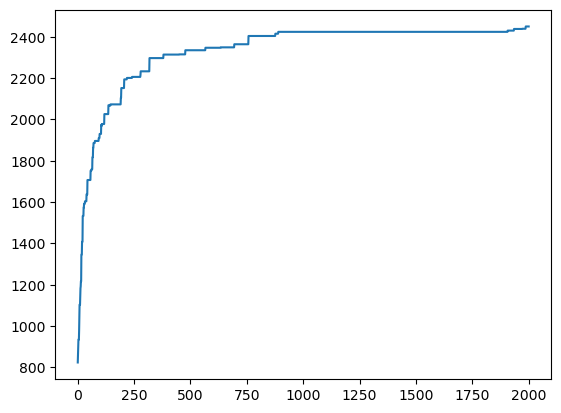

In [10]:
########################################################
# (10 Points)                                          #
# Plot the value of states changes over iterations.    #
########################################################
n = len(records)
x_axis = []
y_axis = []
for i in range(0, n // 2):
    x_axis.append(i + 1)
    y_axis.append(records[2 * i])
plt.plot(x_axis, y_axis)
plt.show()

For better evaluation now just test your algorithm on more examples and see the average value of the best solutions.

In [11]:
def test_algorithm(number_of_tests):
    sum_best_values = 0
    for i in range(number_of_tests):
        weights = [random.randint(0, 50) for _ in range(100)]
        values = [random.randint(0, 75) for _ in range(100)]
        W = 1000
        best_value, best_solution, _ = simulated_annealing(W, weights, values, alpha=0.99, neighbour_prob=0.2, initial_state_true_prob=0.2)
        print(f'best value sample {i + 1}: {best_value}')
        print(f'weight used sample {i + 1}: {np.dot(best_solution, weights)}')
        sum_best_values += best_value
    return sum_best_values / number_of_tests


In [12]:
# (15 Points)
# Reaching 2400 is good enough.

print(f"Average of best values that algorithm reached is {test_algorithm(20)}")

best value sample 1: 2805
weight used sample 1: 1000
best value sample 2: 2777
weight used sample 2: 998
best value sample 3: 3044
weight used sample 3: 996
best value sample 4: 2734
weight used sample 4: 999
best value sample 5: 2701
weight used sample 5: 995
best value sample 6: 2504
weight used sample 6: 1000
best value sample 7: 2749
weight used sample 7: 999
best value sample 8: 2239
weight used sample 8: 986
best value sample 9: 2725
weight used sample 9: 997
best value sample 10: 2949
weight used sample 10: 995
best value sample 11: 2594
weight used sample 11: 996
best value sample 12: 2505
weight used sample 12: 993
best value sample 13: 2659
weight used sample 13: 999
best value sample 14: 2451
weight used sample 14: 997
best value sample 15: 2640
weight used sample 15: 998
best value sample 16: 2616
weight used sample 16: 999
best value sample 17: 2656
weight used sample 17: 995
best value sample 18: 2600
weight used sample 18: 1000
best value sample 19: 2666
weight used samp